<a href="https://colab.research.google.com/github/vaibhavraok/GNCIPL-internship/blob/main/Smart_City_Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q kagglehub[pandas-datasets] pandas numpy scikit-learn matplotlib seaborn plotly geopandas

In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [19]:
# ---- Config ----
DATASET_SLUG = "fedesoriano/air-quality-data-set"
FILE_PATH    = "AirQuality.csv"   # file inside the dataset
RANDOM_STATE = 42
TSNE_ENABLE  = False

print("Downloading dataset via KaggleHub…")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    DATASET_SLUG,
    FILE_PATH,
    pandas_kwargs={"sep": ";", "decimal": ",", "encoding": "latin1"}
)

print("Loaded dataset:", df.shape)
display(df.head())

Loaded dataset: (9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [20]:
df_clean = df.copy()

# Drop empty columns
df_clean = df_clean.dropna(axis=1, how="all")

# Replace missing sentinel
df_clean = df_clean.replace(-200, np.nan)

# Convert columns to numeric if possible
for col in df_clean.columns:
    if col.lower() in ["date", "time", "datetime"]:
        continue
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Keep only numeric features
X = df_clean.select_dtypes(include=[np.number]).copy()
X = X.dropna(axis=1, how="all")
X = X.fillna(X.mean(numeric_only=True))

print("\n--- Post-cleaning numeric matrix ---")
print("Shape:", X.shape)
print("Remaining NaNs:", X.isna().sum().sum())
print("Columns used:", X.columns.tolist())



--- Post-cleaning numeric matrix ---
Shape: (9471, 13)
Remaining NaNs: 0
Columns used: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_scaled)
print("\nPCA(2) explained variance ratio:", pca2.explained_variance_ratio_)

# PCA auto (~90% variance)
pca_auto = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca_auto = pca_auto.fit_transform(X_scaled)
print("PCA(auto, ~90%) components:", X_pca_auto.shape[1])



PCA(2) explained variance ratio: [0.51518602 0.18802217]
PCA(auto, ~90%) components: 5



Auto-selected K: 2 with Silhouette = 0.3392


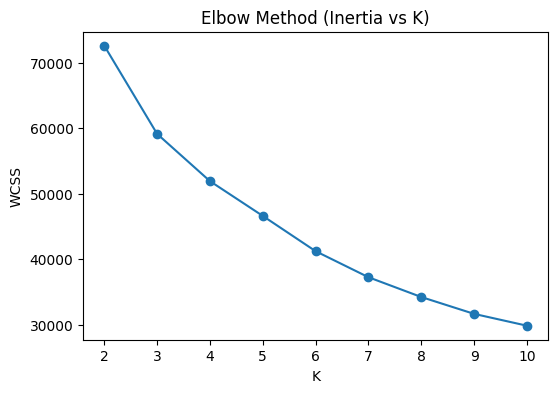

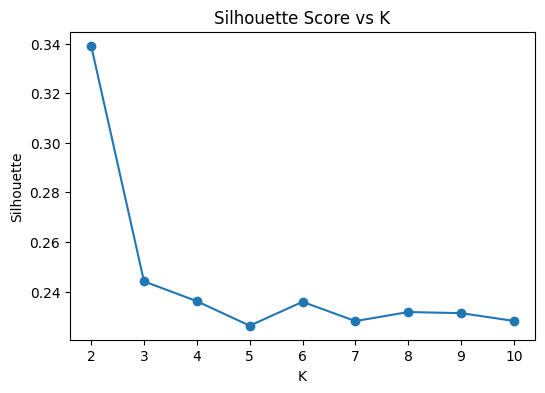

In [22]:
best_k = None
best_sil = -1
silhouette_scores = {}
inertias = {}

for k in range(2, min(11, X_pca_auto.shape[0])):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_pca_auto)
    sil = silhouette_score(X_pca_auto, labels)
    silhouette_scores[k] = sil
    inertias[k] = km.inertia_
    if sil > best_sil:
        best_sil = sil
        best_k = k

print(f"\nAuto-selected K: {best_k} with Silhouette = {best_sil:.4f}")

# Plot curves
plt.figure(figsize=(6,4))
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K"); plt.ylabel("WCSS")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("K"); plt.ylabel("Silhouette")
plt.show()


In [23]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
labels = kmeans.fit_predict(X_pca_auto)

sil = silhouette_score(X_pca_auto, labels)
dbi = davies_bouldin_score(X_pca_auto, labels)
print(f"\nFinal Model → K={best_k} | Silhouette={sil:.4f} | Davies-Bouldin={dbi:.4f}")

out = df_clean.copy().reset_index(drop=True)
out["Cluster"] = labels



Final Model → K=2 | Silhouette=0.3392 | Davies-Bouldin=1.1993


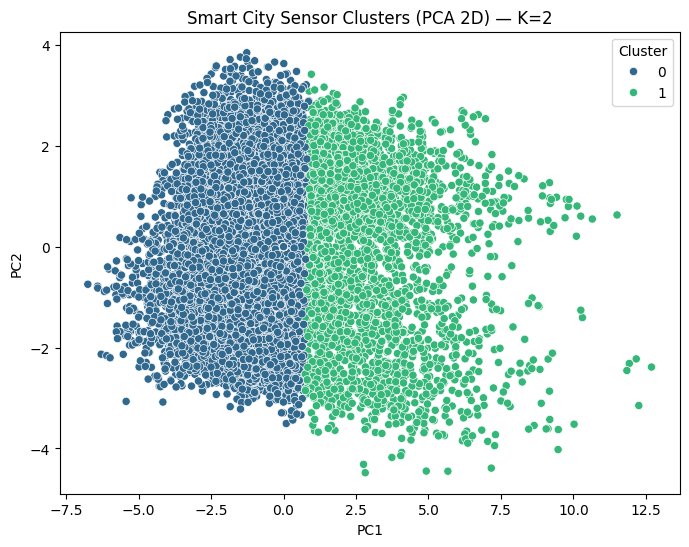

In [25]:
# PCA scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=labels, palette="viridis", s=35)
plt.title(f"Smart City Sensor Clusters (PCA 2D) — K={best_k}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# Interactive Plotly
fig = px.scatter(
    x=X_pca2[:,0], y=X_pca2[:,1],
    color=pd.Series(labels, name="Cluster").astype(str),
    title=f"Interactive PCA Clusters (K={best_k})"
)
fig.show()

# Optional t-SNE
if TSNE_ENABLE:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette="viridis", s=35)
    plt.title(f"t-SNE Visualization — K={best_k}")
    plt.show()


In [26]:
print("\n--- Cluster Summary (numeric means) ---")
summary = out.groupby("Cluster").mean(numeric_only=True)
display(summary)

out.to_csv("smart_city_sensor_clusters.csv", index=False)
summary.to_csv("smart_city_sensor_cluster_summary.csv")

print("Saved clustered data → smart_city_sensor_clusters.csv")
print("Saved summary → smart_city_sensor_cluster_summary.csv")



--- Cluster Summary (numeric means) ---


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Cluster,,,,,,,,,,,,,
0,1.341862,982.571547,108.953947,5.973184,791.561952,145.559332,949.153681,92.125870,1317.666170,807.044830,17.814888,49.081423,0.997732
1,3.691843,1340.446368,437.091503,18.516395,1242.001358,436.635653,602.270536,152.344751,1740.659538,1465.839443,19.349830,49.547692,1.082571


Saved clustered data → smart_city_sensor_clusters.csv
Saved summary → smart_city_sensor_cluster_summary.csv
